In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from vae import Base, LMCVAE
from samplers import HMC, run_chain
#import yaml
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

%matplotlib widget

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
pl.__version__

'2.1.2'

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
def generate_dataset(N, eps0=None, d=2, sigma=1.):
    seed_everything(42)
    z = np.random.randn(N, d)
    x = 2 * np.pi * (np.linalg.norm(z, axis=1, keepdims=True) + 2.) + np.random.randn(N, 1) * sigma
    return x


class Toy(Base):   
    def joint_logdensity(self, use_true_decoder=None):
        def density(z, x):
            if (use_true_decoder is not None) and use_true_decoder:
                x_reconst = self(z)
            elif hasattr(self, 'use_cloned_decoder') and self.use_cloned_decoder:
                x_reconst = self.cloned_decoder(z)
            else:
                x_reconst = self(z)
            log_Pr = torch.distributions.Normal(loc=torch.tensor(0., device=x.device, dtype=torch.float32),
                                    scale=torch.tensor(1., device=x.device, dtype=torch.float32)).log_prob(
                    z).sum(-1)
            
            return torch.distributions.Normal(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2) + 0. * self.decoder_net.aux,
                                                  scale=self.decoder_net.sigma).log_prob(x).sum(-1) + log_Pr

        return density
    
    
class LMCVAE_Toy(LMCVAE, Toy):
    def loss_function(self, sum_log_weights):
        loss = super(LMCVAE_Toy, self).loss_function(sum_log_weights)

        return loss


In [7]:
class ToyDataset(Dataset):
    def __init__(self, data):
        super(ToyDataset, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = torch.tensor(self.data[item], dtype=torch.float32, device=device)
        return sample, -1.

In [8]:
class ToyEncoder(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 2*d),
            nn.LeakyReLU(),
            nn.Linear(2*d, 2*d),
        )

    def forward(self, x):
        return self.net(x)

    
class ToyDecoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.aux = nn.Parameter(torch.tensor(0., dtype=torch.float32))
        self.log_alpha = nn.Parameter(torch.tensor(0, device=device, dtype=torch.float32))
        self.log_beta = nn.Parameter(torch.tensor(0., device=device, dtype=torch.float32))
        self.sigma = sigma

    @property
    def alpha(self,):
        return torch.exp(self.log_alpha)
    
    @property
    def beta(self,):
        return torch.exp(self.log_beta)

    def forward(self, x):
        return self.alpha * (torch.sqrt(torch.sum(torch.pow(x, 2), dim=1, keepdim=True)) + self.beta) # + torch.randn_like(x[:, :1]) * self.sigma + 0. * self.aux
    
class TrueDecoder(nn.Module):
    def __init__(self, d, sigma, eps=None):
        super().__init__()
        self.register_buffer('eps', torch.tensor(eps, dtype=torch.float32))
        self.aux = nn.Parameter(torch.tensor(0., dtype=torch.float32))
        self.sigma = sigma

    def forward(self, z):
        return 2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2.) # + t

In [9]:
N = 10000
d = 2
sigma = 1.
eps = 2 + np.random.randn(1, d)
X_train = generate_dataset(N=N, eps0=eps, d=d, sigma=sigma)
X_val = generate_dataset(N=N // 100, eps0=eps, d=d, sigma=sigma)
train_dataset = ToyDataset(data=X_train)
val_dataset = ToyDataset(data=X_val)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True,)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [10]:
X_train

array([[16.15425872],
       [23.24854695],
       [13.71040989],
       ...,
       [18.52734025],
       [19.64883619],
       [27.15345093]])

In [11]:
def replace_enc_dec(model):
    model.encoder_net = ToyEncoder(d=d)
    model.decoder_net = TrueDecoder(d=d, eps=eps, sigma=sigma)
    model = model.to(device)
    return model

In [12]:
seed_everything(42)
lmcvae = LMCVAE_Toy(shape=28, act_func=nn.LeakyReLU,
            num_samples=1, hidden_dim=d,
            net_type='conv', dataset='toy',
            step_size=0.01, K=5, use_transforms=False, learnable_transitions=False, return_pre_alphas=True, use_score_matching=False,
                      ula_skip_threshold=0.1, grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=True,
                     acceptance_rate_target=0.9, annealing_scheme='all_learnable')
lmcvae = replace_enc_dec(lmcvae)
lmcvae.name = 'LMCVAE'

In [13]:
def run_trainer(model):
    seed_everything(42)
    tb_logger = pl_loggers.TensorBoardLogger('lightning_logs/')
    trainer = pl.Trainer(logger=tb_logger, fast_dev_run=False, max_epochs=31, ) #automatic_optimization=True
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [14]:
run_trainer(lmcvae)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type        | Params
------------------------------------------------
0 | encoder_net     | ToyEncoder  | 28    
1 | decoder_net     | TrueDecoder | 1     
2 | transitions_nll | ModuleList  | 8     
3 | transitions     | ModuleList  | 10    
  | other params    | n/a         | 5     
------------------------------------------------
34        Trainable params
18        Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/yaroslavkliukin/big_data/adaptive-mcmc/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/yaroslavkliukin/big_data/adaptive-mcmc/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=31` reached.


In [15]:
n_leapfrogs = 5
step_size = 0.01
n_samples = 10000
hmc = HMC(n_leapfrogs=n_leapfrogs, step_size=step_size, partial_ref=False, use_barker=False).to(device)
X_item = torch.tensor([[2 * np.pi * (2. + 2.)]], device=device, dtype=torch.float32)

In [16]:
## Receive true posterior sample:
target_density = lambda z, x: torch.distributions.Normal(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2.), scale=sigma).log_prob(X_item.repeat(n_samples, 1)).sum(
    -1) + torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                     scale=torch.tensor(1., device=device, dtype=torch.float32)).log_prob(z).sum(-1)

true_posterior_samples = run_chain(kernel=hmc, z_init=torch.randn(n_samples, 2, device=device), target=target_density, return_trace=False, n_steps=1, burnin=500).cpu().numpy()

In [17]:
def receive_model_samples(model, X_item, stacked=False):
    with torch.no_grad():
        x = X_item
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=n_samples)
        if model.name in ['LMCVAE', 'AMCVAE']:
            model_samples_init = model_samples
            model_samples = model.run_transitions(z=model_samples, x=x.repeat(n_samples, 1), mu=mu, logvar=logvar)[0]
        elif model.name in ['VAE_with_Flows']:
            model_samples = model.Flow(model_samples)[0]
    return model_samples.cpu().numpy()

def plot_contours(model, X_item, stacked=False, graph=None):
    x = X_item
    with torch.no_grad():
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=n_samples)
        logprobs = torch.distributions.Normal(loc=mu, scale=torch.exp(0.5 * logvar)).log_prob(model_samples).sum(-1)
#     plt.contour(model_samples[:, 0].cpu()[..., None], model_samples[:, 1].cpu()[..., None], logprobs.cpu()[..., None])
    if graph is None:
        plt.scatter(model_samples[:, 0].cpu(), model_samples[:, 1].cpu(),)
    else:
        graph.x = model_samples[:, 0].cpu()
        graph.y = model_samples[:, 1].cpu()
        graph.plot_joint(plt.scatter, marker='x', c='g', s=50, alpha=0.5)
    

def receive_posterior_samples(model, n_samples, stacked=False):
    with torch.no_grad():
        model_target_density = lambda z, x: model.joint_logdensity()(z=z, x=X_item.repeat(n_samples, 1))
        model_posterior_samples = run_chain(kernel=hmc, z_init=torch.randn(n_samples, 2, device=device), target=model_target_density, return_trace=False, n_steps=1, burnin=500).cpu().numpy()
    return model_posterior_samples

In [18]:
lmcvae_sample = receive_model_samples(lmcvae, X_item)
lmcvae_posterior_sample = receive_posterior_samples(lmcvae, n_samples)

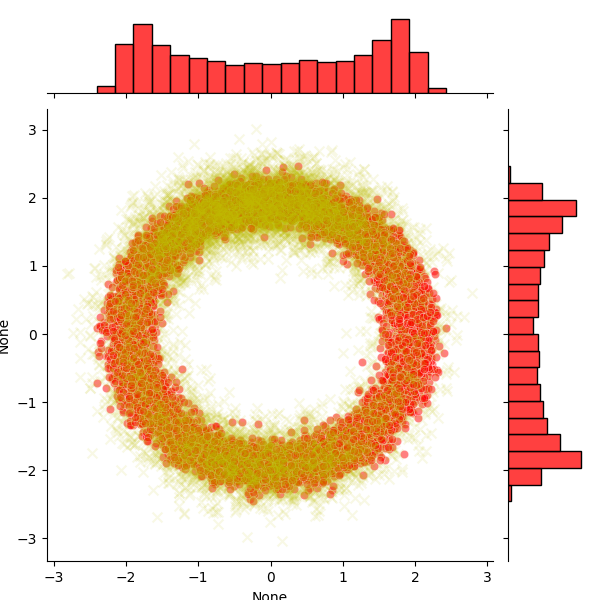

In [19]:
graph = sns.jointplot(x=true_posterior_samples[:, 0], y=true_posterior_samples[:, 1], color='r', alpha=0.5)

graph.x = lmcvae_sample[:, 0]
graph.y = lmcvae_sample[:, 1]
graph.plot_joint(plt.scatter, marker='x', c='y', s=50, alpha=0.1)

In [33]:
def plot_heatmap(samples, x_limits, y_limits, title=None, gamma=0.75, name='default.png'):
    import matplotlib.colors as mcolors
    from scipy.stats import kde
    plt.close()
    plt.figure(figsize=(2, 2), dpi=300)
    
    x = samples[:, 0]
    y = samples[:, 1]
    nbins = 300
    k = kde.gaussian_kde([x,y], bw_method=0.1)
    xi, yi = np.mgrid[x_limits[0]:x_limits[1]:nbins*1j, y_limits[0]:y_limits[1]:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Make the plot
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
    plt.axis('off')
    plt.xlim((x_limits[0], x_limits[1]))
    plt.ylim((y_limits[0], y_limits[1]))
#     plt.axis('equal')
    plt.tight_layout()
    plt.savefig(name, format='png')
    plt.show()

/tmp/ipykernel_1333/2059705657.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y], bw_method=0.1)


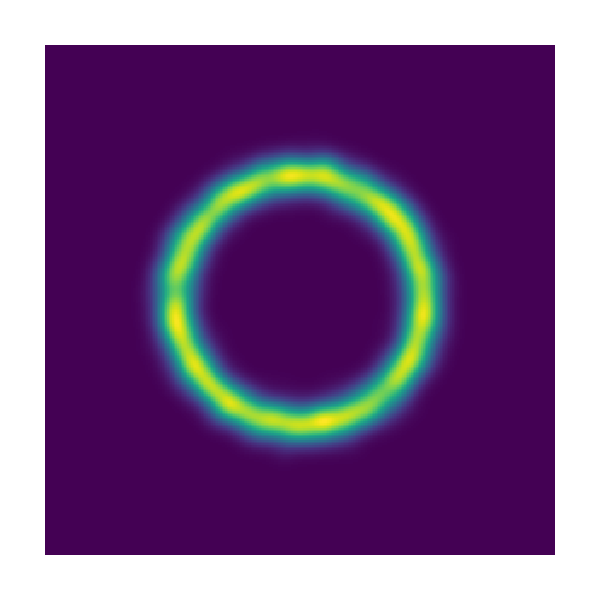

In [34]:
plot_heatmap(true_posterior_samples, (-4, 4), (-4, 4), title=None, gamma=0.5, name='true_posterior.png')

/tmp/ipykernel_1333/2059705657.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y], bw_method=0.1)


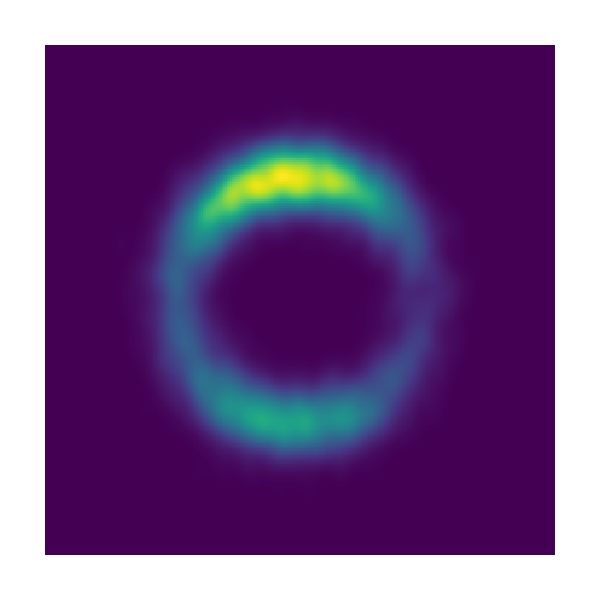

In [35]:
plot_heatmap(lmcvae_sample, (-4, 4), (-4, 4), title=None, gamma=0.5, name='lmcvae.png')